In [1]:
'''This script demonstrates how to entangle digit with fashion mnist
'''
import sys, os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
import keras
sys.path.append(os.path.expanduser('~/notebook'))
from tools import plot_confusion_matrix, plot_model, layers, nb_tools, viz, loader, build_model, sanity, sampling, custom_variational_layer, metrics, build_model

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
beta = 4.0
use_fashion = 1
epochs = 100
batch_size = 128

try:
    _beta = np.float(os.environ['BETA'])
    _label = np.int(os.environ['LABEL'])
    _epochs = np.int(os.environ['EPOCHS'])
    _use_fashion = np.int(os.environ['USE_FASHION'])
    _latent_dim = np.int(os.environ['DIM_LATENT'])
    latent_dim = _latent_dim
    beta = _beta
    label = _label
    epochs = _epochs
    use_fashion = _use_fashion
    print("WARNING: Set parameters from environment")
except:
    pass

model_obj = build_model.GenericVae()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# train the VAE on MNIST digits
if use_fashion==1:
    x_train, y_train, x_test, y_test = loader.mnist(new_shape = original_img_size, kind='fashion', get_single_label = label)
else:
    x_train, y_train, x_test, y_test = loader.mnist(new_shape = original_img_size, kind='digit', get_single_label = label)
print(x_train.shape)
print(y_train.shape)

NameError: name 'label' is not defined

Loaded model from disk
Loaded model from disk
----------------- label:  0


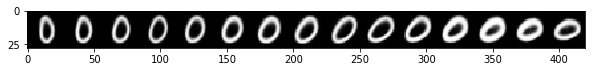

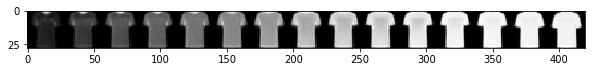

Loaded model from disk
Loaded model from disk
----------------- label:  1


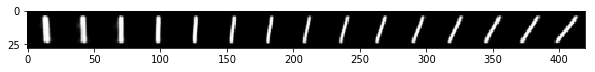

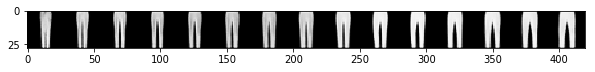

Loaded model from disk
Loaded model from disk
----------------- label:  2


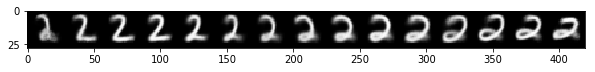

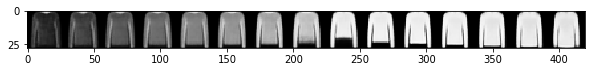

Loaded model from disk
Loaded model from disk
----------------- label:  3


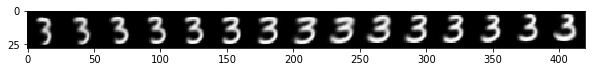

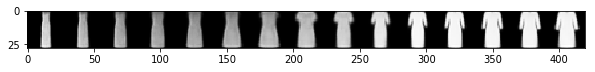

Loaded model from disk
Loaded model from disk
----------------- label:  4


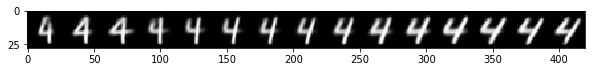

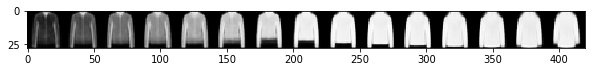

Loaded model from disk
Loaded model from disk
----------------- label:  5


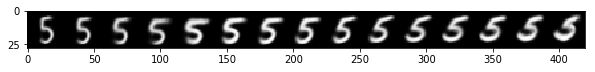

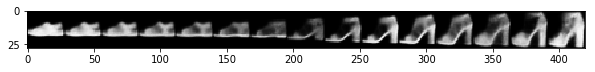

Loaded model from disk
Loaded model from disk
----------------- label:  6


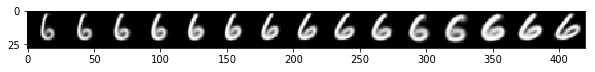

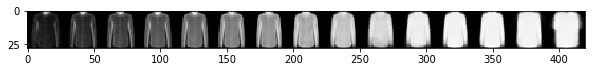

Loaded model from disk
Loaded model from disk
----------------- label:  7


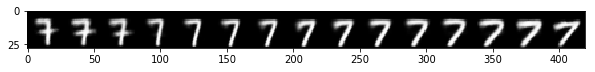

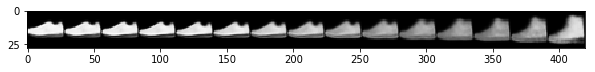

Loaded model from disk
Loaded model from disk
----------------- label:  8


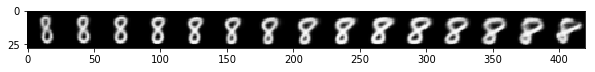

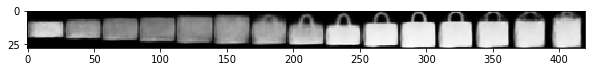

Loaded model from disk
Loaded model from disk
----------------- label:  9


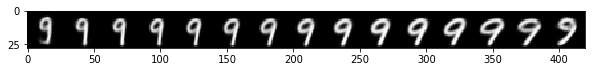

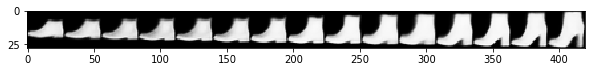

In [4]:
def print_z(generator, label, num_y = None):
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    if num_y is None:
        num_y = n
    digit_size = 28
    figure = np.zeros((digit_size * num_y, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    if num_y is not 1:
        grid_y = norm.ppf(np.linspace(0.05, 0.95, num_y))
    else:
        grid_y = norm.ppf(np.array([0.5]))

    for j, xi in enumerate(grid_x):
        for i, yi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            y_sample_cat = np.zeros((1,10))
            y_sample_cat[0,label] = 1
            x_decoded = generator.predict([z_sample, y_sample_cat])
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show(block=False)

num_samples_pre_class = 7000
# generate samples z
generate_samples = False
z = np.random.normal(0, 1, (5 * num_samples_pre_class, latent_dim))
z = z[np.linalg.norm(z, 2, axis=1) < norm.ppf(0.95),:]
z = z[:num_samples_pre_class,:]
if generate_samples == True:

    x_digits = []
    x_fashion = []
    x_label = []
    print(z.shape)

for label in np.arange(0,10):
    # generate samples for new dataset    
    y_cat = np.zeros((num_samples_pre_class,10))
    y_cat[:,label] = 1
    # digits
    use_fashion = 0
    prefix = "eMNSIT_CVAE_fashion-" + str(use_fashion) + "_latent_dim-" + str(latent_dim) + "_beta-" + str(beta) + "_epochs-" + str(epochs)
    decoder_digit = model_obj.load_model(prefix + "_model-decoder")
    #encoder_logvar_digit = model_obj.load_model(prefix + "_model-encoder-logvar")
    #encoder_mean_digit = model_obj.load_model(prefix + "_model-encoder-mean")
    x_digit_decoded = decoder_digit.predict([z, y_cat])
    # fashion
    use_fashion = 1
    prefix = "eMNSIT_CVAE_fashion-" + str(use_fashion) + "_latent_dim-" + str(latent_dim) + "_beta-" + str(beta) + "_epochs-" + str(epochs)
    decoder_fashion = model_obj.load_model(prefix + "_model-decoder")
    #encoder_logvar_fashion = model_obj.load_model(prefix + "_model-encoder-logvar")
    #encoder_mean_fashion = model_obj.load_model(prefix + "_model-encoder-mean")
    x_fashion_decoded = decoder_fashion.predict([z, y_cat])
    num_y = np.int(1)
    print("----------------- label: ", label)
    # plot the decoded images
    print_z(decoder_digit, label, num_y = num_y)
    print_z(decoder_fashion, label, num_y = num_y)
    # generate the samples
    if generate_samples == True:
        if label == 0:
            x_digits = np.copy(x_digit_decoded)
            x_fashion = np.copy(x_fashion_decoded)
        else:
            x_digits = np.concatenate((x_digits, x_digit_decoded), axis=0)
            x_fashion = np.concatenate((x_fashion, x_fashion_decoded), axis=0)
        x_label = np.concatenate((x_label, label * np.ones((num_samples_pre_class,))), axis=0)
if generate_samples == True:
    prefix = "eMNSIT_CVAE_latent_dim-" + str(latent_dim) + "_beta-" + str(beta) + "_epochs-" + str(epochs)
    np.savez_compressed(prefix, x_digits=x_digits, x_fashion=x_fashion, x_label=x_label)


In [4]:
#from scipy.stats import norm
#print(norm.ppf(np.linspace(0.05, 0.95, 3)))